<img src="../../images/BikeDNA_logo.svg" width="250"  alt="BikeDNA logo" style="display:block; margin-left: auto; margin-right: auto;">
<a href="https://github.com/anerv/BikeDNA">Github</a>

# 1.初始化OSM数据

这本笔记本：

- 加载定义研究区域的多边形，然后为研究区域创建网格叠加。
- 使用 OSMnx 下载研究区域的街道网络数据。
- 仅使用自行车基础设施创建网络（使用“config.yml”中定义的查询）。
- 在数据中创建用于分析的附加属性。

<div class="alert alert-block alert-info">
<b>Prerequisites &amp; Input/Output</b>
<p>
<span style="font-family:courier;">config.yml</span> 必须提前设置。
    
此笔记本的输出文件保存到 <span style="font-family:courier;">../data/OSM/[study_area]/processed/</span> 子文件夹中，并在笔记本 1b、3a 和 3b 中使用。

当根据 OSM 数据创建网络时，简化和非简化网络中的每条边都会分配一个唯一的边 ID（而非 OSM ID）。 要将边缘 ID 与 OSM ID 关联起来，数据帧与网络边缘、<span style="font-family:courier;">osm_edges</span> 和 <span style="font-family:courier;">osm_edges_simplified </span>，可以使用。
</p>
</div>

**章节**
* [加载研究区域数据并创建分析网格](#Load-data-for-study-area-and-create-analysis-grid)
* [下载并预处理OSM数据](#Download-and-preprocess-OSM-data)

<br />

## 加载研究区域数据并创建分析网格

这一步：

- 从配置文件“config.yml”加载分析设置。
- 读取研究区域的数据。
- 创建研究区域的网格覆盖，网格单元大小在“config.yml”中定义。

<div class="alert alert-block alert-warning">
<b>故障排除</b>
<p>
如果在下面的单元格中位于 <i>src</i> 文件夹中的函数无法正确加载：检查 <span style="font-family:courier;">pip install -e .</span> 是否已运行 成功（请参阅 <span style="font-family:courier;">README.md</span> 中的说明）。
</p>
</div>

In [13]:
# Load libraries, settings and data

import json
import pickle
import warnings
from datetime import datetime

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import numpy as np
import yaml

from src import evaluation_functions as eval_func
from src import graph_functions as graph_func
from src import simplification_functions as simp_func
from src import plotting_functions as plot_func

%run ../settings/plotting.py
%run ../settings/yaml_variables.py
%run ../settings/paths.py

warnings.filterwarnings("ignore")

### 加载研究区域的数据

研究区域由用户提供的多边形定义。 它将用于计算**全局**结果，即基于研究区域所有数据的质量指标。

In [14]:
# Load polygon for study area

study_area_poly = gpd.read_file(study_area_poly_fp)

if study_area_poly.crs == None:
    print("Please assign a crs to the study area polygon!")

if study_area_poly.crs != study_crs:
    study_area_poly = study_area_poly.to_crs(study_crs)

assert study_area_poly.crs == study_crs

area = study_area_poly.area.values[0]
print(f"The size of the study area is {area / 1000000:.2f} km2.")

The size of the study area is 181.38 km2.


This study area will be used for the analysis:


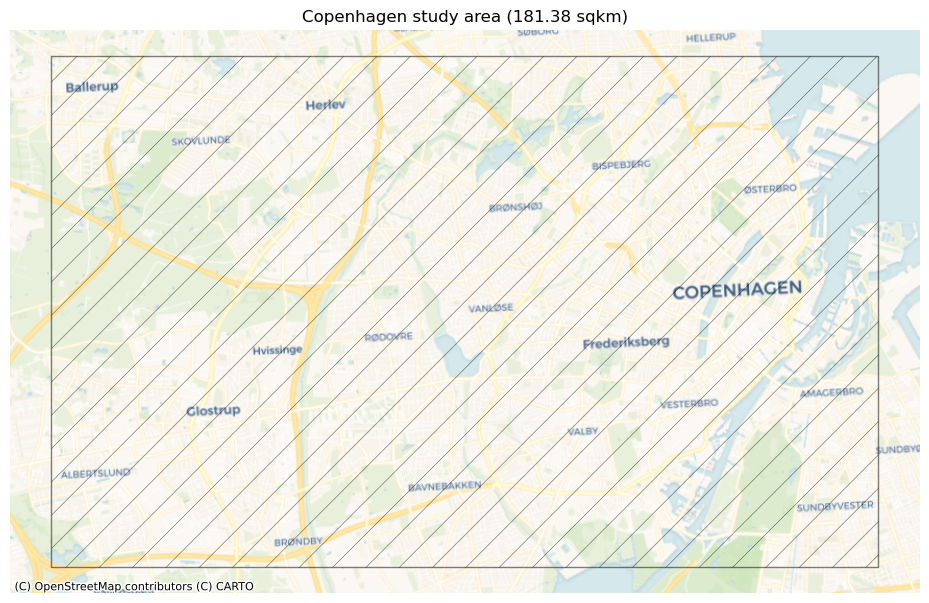

In [15]:
# Plot study area

set_renderer(renderer_map)
print("This study area will be used for the analysis:")

fig, ax = plt.subplots(1, figsize=pdict["fsmap"])
study_area_poly.plot(ax=ax, edgecolor=pdict["base"], facecolor='none',alpha=pdict["alpha_back"],hatch='/')
ax.set_axis_off()
cx.add_basemap(ax, crs=study_area_poly.crs, source=cx_tile_1)
ax.set_title(f"{area_name} study area ({area / 1000000:.2f} sqkm)")

plot_func.save_fig(fig, osm_results_static_maps_fp + "area_size_osm")

### 创建分析网格

<div class="alert alert-block alert-info">
<b>用户配置</b>
<p>
网格用于计算许多质量指标的<b>本地</b>结果，即在网格单元级别上。 网格单元的单元大小必须在配置文件中指定。 较小的网格单元会增加计算时间，但会给出更精细的结果。 网格单元大小不应小于您预期数据质量实际差异的比例。
</p>
</div>

The grid contains 2088 square cells with a side length of 300 m and an area of 0.09 km2.
This grid will be used for local (grid cell level) analysis:


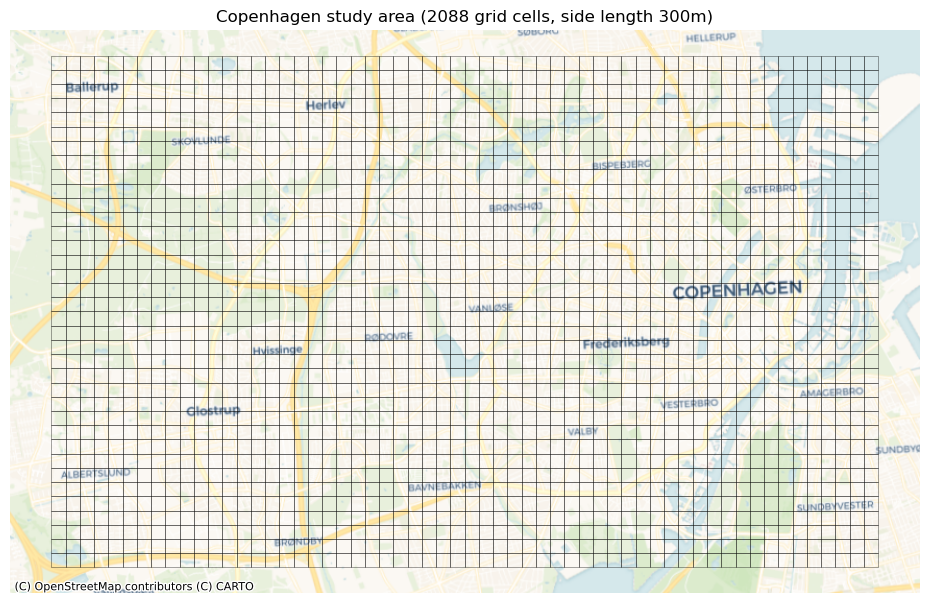

In [16]:
# Create and plot grid

set_renderer(renderer_map)

grid = eval_func.create_grid_geometry(study_area_poly, grid_cell_size)
grid["grid_id"] = grid.index

fig, ax = plt.subplots(1, figsize=pdict["fsmap"])
grid_cell_area = (grid_cell_size / 1000) ** 2  # in km2
print(f"The grid contains {len(grid)} square cells with a side length of {grid_cell_size} m and an area of {grid_cell_area:.2f} km2.")
print("This grid will be used for local (grid cell level) analysis:")
grid.plot(ax=ax, facecolor="none", edgecolor=pdict["base"], alpha=pdict["alpha_back"],linewidth=0.5)
ax.set_axis_off()
cx.add_basemap(ax, crs=study_area_poly.crs, source=cx_tile_1)
ax.set_title(
    f"{area_name} study area ({len(grid)} grid cells, side length {grid_cell_size}m)"
)

plot_func.save_fig(fig, osm_results_static_maps_fp + "area_grid_osm")

## 下载并预处理OSM数据

这一步：

- 使用 OSMnx 从 OpenStreetMap 下载数据。
- 将数据投影到所选的 CRS。
- 创建一个仅由自行车基础设施组成的子网。
- 根据自行车网络中的所有边缘是否受保护或不受保护的自行车基础设施、它们的数字化方式以及是否允许双向行驶，对自行车网络中的所有边缘进行分类。
- 简化网络。
- 创建由相交网格单元索引的所有边和节点数据集的副本。

**OSM数据模型**

在 OSM 中，街道网络数据使用*节点*（点）和*路径*（线）存储。 在 BikeDNA 中，OSM 数据被转换为由*节点*和*边*组成的网络结构（我们使用 OSMnx 中使用的术语）。 边代表实际的基础设施，例如自行车道和路径，而节点代表边的起点和终点以及所有交叉路口。 有关更多详细信息，请阅读有关 [OSM 数据模型](https://alga.win.tue.nl/tutorials/openstreetmap/) 和 [网络数据模型](https://networkx.org/documentation/stable /reference/introduction.html）。

<summary><b>网络简化</b></summary>

将一组线串转换为网络（图形）格式时，并非所有顶点（节点）都具有相同的含义。 对于边的几何形状，所有节点都用于定义边的形状。 然而，对于网络的拓扑，仅需要那些作为端点或与其他边的交点的节点，而所有其他（所谓的“间隙”）节点不添加任何信息。 为了比较网络中节点和边之间的结构和真实比率，需要简化的网络表示，仅包括端点和交叉点处的节点，或者重要属性值发生变化的位置。 简化网络的另一个优点是节点和边的数量大幅减少，这使得计算例程更快。

请注意，简化函数仅简化并合并具有相同重要属性（例如几何类型、自行车方向和保护级别）值的边。

<p align="center">
<img src='../../images/network_simplification_illustration.png' width=300/>

*非简化网络（左）和简化网络（右）*。

</p>

作为简化例程的一部分，如果同一对节点之间存在多条边（“平行边”或“多重边”），则仅保留其中一条边。

要了解有关此处使用的修改后的 OSMnx 简化 [(Boeing, 2017)](https://geoffboeing.com/publications/osmnx-complex-street-networks/) 的更多信息，我们参考此 [GitHub 存储库](https://geoffboeing.com/publications/osmnx-complex-street-networks/) /github.com/anerv/NERDS_osmnx）其中包含简化函数、逻辑解释和演示。



<div class="alert alert-block alert-danger">
<b>警告</b>
<p>
根据研究区域的大小，通过 OSMnx 获取数据可能需要一些时间（对于哥本哈根大小的城市可能需要两分钟）。
</p>
</div>

<div class="alert alert-block alert-info">
<b>用户配置</b>
<p>
在接下来的步骤中，从一般街道网络中提取专用自行车基础设施。 根据您所在地区的自行车基础设施类型和 OSM 标记传统，用于检索自行车网络的查询可能需要进行调整（这在<i>bicycle_infrastruction_queries</i>下的配置文件中完成）。
</p>
</div>

In [17]:
# Download OSM data

ox.settings.use_cache = False
ox.settings.useful_tags_way = osm_way_tags

graph_osm = ox.graph_from_polygon(
    study_area_poly.to_crs("EPSG:4326").loc[0, "geometry"],
    network_type="bike",
    simplify=False,
    retain_all=True,
    truncate_by_edge=False,
    clean_periphery=True,
)

print("OSM data retrieved successfully!")

OSM data retrieved successfully!


In [18]:
# Convert into graph

# Project graph to chosen crs
graph_osm = ox.project_graph(graph_osm, to_crs=study_crs)

# Get osm_edges and osm_nodes
osm_nodes, osm_edges = ox.graph_to_gdfs(graph_osm)

# Clean up column names (removing ':' and upper case letters)
osm_edges = graph_func.clean_col_names(osm_edges)
osm_nodes = graph_func.clean_col_names(osm_nodes)

# Add attribute on whether bicycle infra exist or not (to be used by e.g. simplification function)
osm_edges["bicycle_infrastructure"] = "no"

for q in bicycle_infrastructure_queries.values():

    try:
        ox_filtered = osm_edges.query(q)

    except Exception:
        print("Exception occured when quering with:", q)
        print("Please check if the columns used in the query are present in the data")

    osm_edges.loc[ox_filtered.index, "bicycle_infrastructure"] = "yes"

osm_edges.bicycle_infrastructure.value_counts()

bicycle_edges = osm_edges.loc[osm_edges.bicycle_infrastructure == "yes"].copy()

bicycle_graph = graph_osm.edge_subgraph(bicycle_edges.index)
print("Successfully created network only with bicycle infrastructure!")
print("\n")

Successfully created network only with bicycle infrastructure!




In [19]:
# Augment and classify edge types

assert len(bicycle_edges) == len(bicycle_graph.edges)

bicycle_graph = graph_func.update_key_values(bicycle_graph)

bicycle_nodes, bicycle_edges = ox.graph_to_gdfs(bicycle_graph)
bicycle_edges = graph_func.clean_col_names(bicycle_edges)
bicycle_nodes = graph_func.clean_col_names(bicycle_nodes)

bicycle_edges["bicycle_infrastructure"] = "yes"
bicycle_infrastructure_dict = bicycle_edges["bicycle_infrastructure"].to_dict()
nx.set_edge_attributes(
    bicycle_graph, bicycle_infrastructure_dict, "bicycle_infrastructure"
)

# Add "multiple edge" attribute to each edge of the graph
for e in bicycle_graph.edges:
    bicycle_graph.edges[e]["multiedge"] = 0

# Count multiple edges and store info at key 0
# (simplification routine keeps only key 0)
for u, v, k in bicycle_graph.edges:
    if k > 0:
        bicycle_graph.edges[u, v, 0]["multiedge"] += 1

# Define whether bicycle infrastructure is in both or one direction and whether it is one- or bidirectional
bicycle_edges = eval_func.simplify_bicycle_tags(bicycle_edges,simplify_tags_queries)

for key, value in bicycle_edges.bicycle_bidirectional.value_counts().items():
    perc = np.round(100*value/len(bicycle_edges),2)
    print(f"Edges where 'bicycle_bidirectional' is {key}: {value} out of {len(bicycle_edges)} ({perc}%)")
print("\n")

for key, value in bicycle_edges.bicycle_geometries.value_counts().items():
    perc = np.round(100*value/len(bicycle_edges),2)
    print(f"Edges where the geometry type is '{key}': {value} out of {len(bicycle_edges)} ({perc}%)")
print("\n")

bicycle_bidirectional_dict = bicycle_edges["bicycle_bidirectional"].to_dict()
nx.set_edge_attributes(
    bicycle_graph, bicycle_bidirectional_dict, "bicycle_bidirectional"
)

bicycle_geometries_dict = bicycle_edges["bicycle_geometries"].to_dict()
nx.set_edge_attributes(bicycle_graph, bicycle_geometries_dict, "bicycle_geometries")

# Classify edges as protected or unprotected
bicycle_edges = eval_func.define_protected_unprotected(
    bicycle_edges, osm_bicycle_infrastructure_type
)

# Set edges attributes for column protected
bicycle_protected_dict = bicycle_edges["protected"].to_dict()
nx.set_edge_attributes(bicycle_graph, bicycle_protected_dict, "protected")

for key, value in bicycle_edges.protected.value_counts().items():
    perc = np.round(100*value/len(bicycle_edges),2)
    print(f"Edges where the protection level is '{key}': {value} out of {len(bicycle_edges)} ({perc}%)")
print("\n")

# Simplify bicycle network
bicycle_graph_simplified = simp_func.simplify_graph(
    bicycle_graph,
    attributes=[
        "bicycle_infrastructure",
        "bicycle_bidirectional",
        "bicycle_geometries",
        "protected",
    ],
    remove_rings=False,
)

# Get undirected network representation
bicycle_graph_simplified = ox.get_undirected(bicycle_graph_simplified)
bicycle_graph = ox.get_undirected(bicycle_graph)

bicycle_nodes_simplified, bicycle_edges_simplified = ox.graph_to_gdfs(
    bicycle_graph_simplified, nodes=True
)

# Measure the length of bicycle infrastructure (!=from length of edges)
bicycle_edges_simplified["length"] = bicycle_edges_simplified.geometry.length
bicycle_edges_simplified["infrastructure_length"] = bicycle_edges_simplified.apply(
    lambda x: eval_func.measure_infrastructure_length(
        edge=x.geometry,
        geometry_type=x.bicycle_geometries,
        bidirectional=x.bicycle_bidirectional,
        bicycle_infrastructure=x.bicycle_infrastructure,
    ),
    axis=1,
)

# Creating columns with unique feature id (required by some functions)
bicycle_edges["edge_id"] = bicycle_edges.reset_index().index
bicycle_edges_simplified["edge_id"] = bicycle_edges_simplified.reset_index().index

osm_id_dict = bicycle_edges["edge_id"].to_dict()
nx.set_edge_attributes(bicycle_graph, osm_id_dict, "edge_id")

osm_id_dict_s = bicycle_edges_simplified["edge_id"].to_dict()
nx.set_edge_attributes(bicycle_graph_simplified, osm_id_dict_s, "edge_id")

# Saving data to graphs
osm_l_dict = osm_edges["length"].to_dict()
nx.set_edge_attributes(bicycle_graph, osm_l_dict, "length")

osm_l_dict_s = bicycle_edges_simplified["length"].to_dict()
nx.set_edge_attributes(bicycle_graph_simplified, osm_l_dict_s, "length")

osm_il_dict = bicycle_edges_simplified["infrastructure_length"].to_dict()
nx.set_edge_attributes(bicycle_graph_simplified, osm_il_dict, "infrastructure_length")

No update necessary. Returning original bicycle graph.
Edges where 'bicycle_bidirectional' is False: 34894 out of 52168 (66.89%)
Edges where 'bicycle_bidirectional' is True: 17274 out of 52168 (33.11%)


Edges where the geometry type is 'true_geometries': 26410 out of 52168 (50.62%)
Edges where the geometry type is 'centerline': 25758 out of 52168 (49.38%)


Edges where the protection level is 'protected': 48098 out of 52168 (92.2%)
Edges where the protection level is 'unprotected': 3321 out of 52168 (6.37%)
Edges where the protection level is 'mixed': 749 out of 52168 (1.44%)




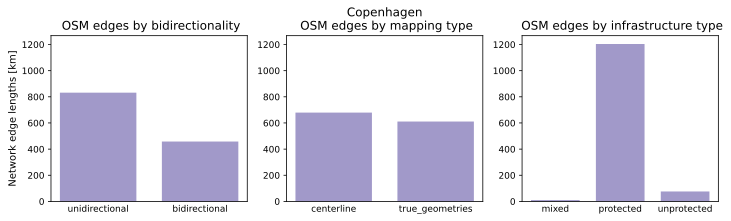

In [20]:
# Plot global statistics (by network length)

set_renderer(renderer_plot)
ymax = bicycle_edges_simplified.infrastructure_length.sum() * 1.2 /1000 # conversion m to km
subplotdata = []
subplotbar_labels = []
subplottitle = []
subplotx_positions = []

# attribute: bidirectional
x = []
y = []

for value in np.unique(bicycle_edges.bicycle_bidirectional):
    x.append(str(value))
    y.append(bicycle_edges[bicycle_edges["bicycle_bidirectional"]==value].length.sum()/1000) # conversion m to km

plot_func.make_bar_plot(
    data = y,
    bar_labels = ["unidirectional", "bidirectional"],
    y_label = "Network edge length [km]",
    x_positions = [i for i in range(len(x))],
    title = f"{area_name}\n OSM edges by bidirectionality",
    bar_colors = len(x)*[pdict["osm_base"]],
    filepath = osm_results_plots_fp + "edge_global_bidirectional",
    ylim = ymax,
    figsize=pdict["fsbar_small"]
); plt.close()
subplotdata.append(tuple(y))
subplotbar_labels.append(["unidirectional", "bidirectional"])
subplottitle.append(f"\n OSM edges by bidirectionality")
subplotx_positions.append([i for i in range(len(x))])

# attribute: bicycle geometry (mapping type)
x = []
y = []

for value in np.unique(bicycle_edges.bicycle_geometries):
    x.append(value)
    y.append(bicycle_edges[bicycle_edges["bicycle_geometries"]==value].length.sum()/1000) # conversion m to km

plot_func.make_bar_plot(
    data = y,
    bar_labels = x,
    y_label = "Network edge lengths [km]",
    x_positions = [i for i in range(len(x))],
    title = f"{area_name}\n OSM edges by mapping type",
    bar_colors = len(x)*[pdict["osm_base"]],
    filepath = osm_results_plots_fp + "edge_global_mappingtype",
    ylim = ymax,
    figsize=pdict["fsbar_small"]
); plt.close()
subplotdata.append(tuple(y))
subplotbar_labels.append(x)
subplottitle.append(f"{area_name}\n OSM edges by mapping type")
subplotx_positions.append([i for i in range(len(x))])

# attribute: protection
x = []
y = []

for value in np.unique(bicycle_edges.protected):
    x.append(value)
    y.append(bicycle_edges[bicycle_edges["protected"]==value].length.sum()/1000) # conversion m to km

plot_func.make_bar_plot(
    data = y,
    bar_labels = x,
    y_label = "Network edge lengths [km]",
    x_positions = [i for i in range(len(x))],
    title = f"{area_name}\n OSM edges by infrastructure type",
    bar_colors = len(x)*[pdict["osm_base"]],
    filepath = osm_results_plots_fp + "edge_global_infrastructuretype",
    ylim = ymax,
    figsize=pdict["fsbar_small"]
); plt.close()
subplotdata.append(tuple(y))
subplotbar_labels.append(x)
subplottitle.append(f"\n OSM edges by infrastructure type")
subplotx_positions.append([i for i in range(len(x))])

# Next to each other
plot_func.make_bar_subplots(
    subplot_data=subplotdata,
    nrows=1,
    ncols=3,
    bar_labels=subplotbar_labels,
    y_label=["Network edge lengths [km]", "", ""],
    x_positions=subplotx_positions,
    title=subplottitle,
    bar_colors=len(x)*[pdict["osm_base"]],
    filepath=osm_results_plots_fp + "edge_global",
    ylim=ymax
);


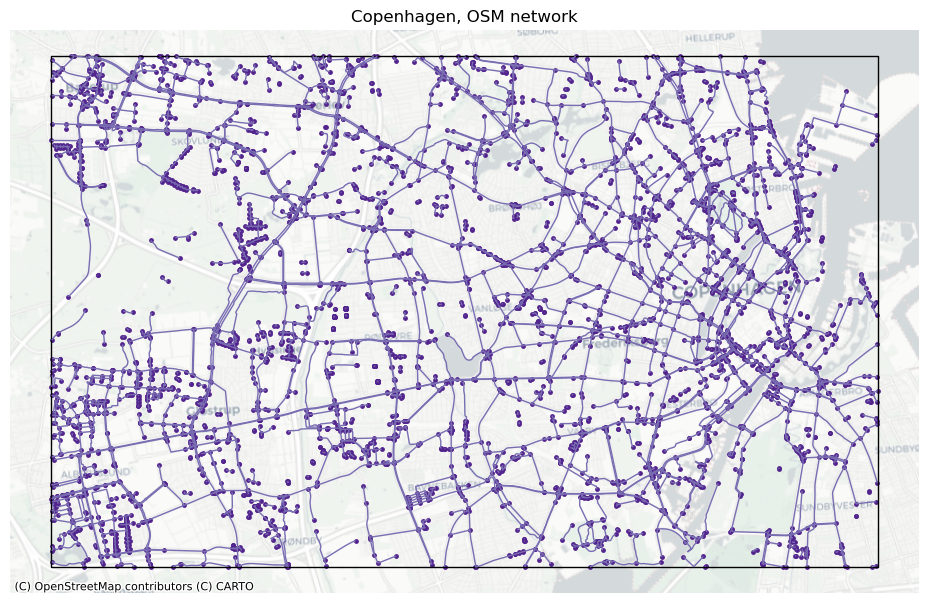

In [ ]:
# Plot network

set_renderer(renderer_map)
fig, ax = plt.subplots(1, figsize=pdict["fsmap"])
bicycle_edges_simplified.plot(ax=ax, color=pdict["osm_base"], linewidth=pdict["line_base"])
bicycle_nodes_simplified.plot(ax=ax, color=pdict["osm_emp"], markersize=pdict["mark_emp"])
study_area_poly.plot(ax=ax, edgecolor=pdict["base"], facecolor="None", linewidth=1)
cx.add_basemap(ax=ax, crs=study_area_poly.crs, source=cx_tile_2)
ax.set_axis_off()
ax.set_title(f"{area_name}, OSM network")

plot_func.save_fig(fig, osm_results_static_maps_fp + "area_network_osm")

In [ ]:
# Joining grid cell id to network elements

osm_edges_simp_joined = gpd.overlay(
    bicycle_edges_simplified.reset_index(), grid, how="intersection"
)
osm_edges_joined = gpd.overlay(bicycle_edges.reset_index(), grid, how="intersection")

osm_nodes_simp_joined = gpd.overlay(
    bicycle_nodes_simplified.reset_index(), grid, how="intersection"
)
osm_nodes_joined = gpd.overlay(bicycle_nodes.reset_index(), grid, how="intersection")

# Count features in each grid cell
all_data_osm = [
    osm_edges_joined,
    osm_nodes_joined,
    osm_edges_simp_joined,
    osm_nodes_simp_joined,
]
labels_osm = ["osm_edges", "osm_nodes", "osm_simplified_edges", "osm_simplified_nodes"]

for data, label in zip(all_data_osm, labels_osm):

    df = eval_func.count_features_in_grid(data, label)

    grid = eval_func.merge_results(grid, df, "left")

# Recomputing infrastructure length for data joined to grid
osm_edges_simp_joined["length"] = osm_edges_simp_joined["geometry"].length
osm_edges_simp_joined["infrastructure_length"] = osm_edges_simp_joined.apply(
    lambda x: eval_func.measure_infrastructure_length(
        edge=x.geometry,
        geometry_type=x.bicycle_geometries,
        bidirectional=x.bicycle_bidirectional,
        bicycle_infrastructure=x.bicycle_infrastructure,
    ),
    axis=1,
)

assert round(bicycle_edges_simplified.infrastructure_length.sum() / 10000, 0) == round(
    osm_edges_simp_joined.infrastructure_length.sum() / 10000, 0
)

In [ ]:
# Save OSM data
exec(open("../settings/save_osmdata.py").read())

OSM nodes and edges saved successfully!
OSM networks saved successfully!
OSM grid saved successfully!


***

In [ ]:
from time import strftime
print("Time of analysis: " + strftime("%a, %d %b %Y %H:%M:%S"))